In [189]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.decomposition import PCA

from sklearn import config_context

import os

import circlify
import plotly.express as px

In [211]:
with config_context(assume_finite=True):
    print("OpenMP active.")

print("Logical active cores:", os.cpu_count())

OpenMP active.
Logical active cores: 8


In [190]:
bankA_data = pd.read_csv("../BankA_Clean.csv")
bankB_data = pd.read_csv("../BankB_Clean.csv")
bankC_data = pd.read_csv("../BankC_Clean.csv")

In [167]:
bankB_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,402923.0,-2.206895e-16,1.000001,-1.514809,-0.820128,-0.125446,0.638704,3.556367
education-num,402923.0,-3.092421e-16,1.000001,-4.954954,-0.453981,-0.453981,0.108640,3.484369
capital-gain,402923.0,3.787934e-17,1.000001,-0.131115,-0.131115,-0.131115,-0.131115,15.645185
capital-loss,402923.0,3.512833e-17,1.000001,-0.214140,-0.214140,-0.214140,-0.214140,9.195915
hours-per-week,402923.0,-2.093592e-16,1.000001,-3.073549,-0.087917,-0.009348,0.383498,4.626237
income,402923.0,2.130109e-01,0.409436,0.000000,0.000000,0.000000,0.000000,1.000000
education_11th,402923.0,1.518901e-02,0.122304,0.000000,0.000000,0.000000,0.000000,1.000000
education_12th,402923.0,5.147385e-03,0.071560,0.000000,0.000000,0.000000,0.000000,1.000000
education_1st-4th,402923.0,2.164185e-03,0.046470,0.000000,0.000000,0.000000,0.000000,1.000000
education_5th-6th,402923.0,4.382971e-03,0.066059,0.000000,0.000000,0.000000,0.000000,1.000000


In [191]:
bankB_data_mod = bankB_data[["income", "age", "hours-per-week", "capital-gain", "capital-loss", "education-num"]]
bankB_data_mod.max()

income             1.000000
age                3.556367
hours-per-week     4.626237
capital-gain      15.645185
capital-loss       9.195915
education-num      3.484369
dtype: float64

In [216]:
labelA_counts = bankA_data["income"].value_counts()
labelB_counts = bankB_data["income"].value_counts()
labelC_counts = bankC_data["income"].value_counts()


print(f"Distribution of 'income' in Bank A: {labelA_counts}")
print(f"Distribution of 'income' in Bank B: {labelB_counts}")
print(f"Distribution of 'income' in Bank C: {labelC_counts}")



Distribution of 'income' in Bank A: income
0.0    142978
1.0     83478
Name: count, dtype: int64
Distribution of 'income' in Bank B: income
0.0    317096
1.0     85827
Name: count, dtype: int64
Distribution of 'income' in Bank C: income
0.0    141457
1.0     29163
Name: count, dtype: int64


<hr>

In [192]:
def get_feature_importance(dataset):
    X = dataset.drop(columns=['income'])
    y = dataset['income']
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    print(feature_importances.head(10))


In [193]:
get_feature_importance(bankA_data)

                              Feature  Importance
0                                 age    0.232401
21  marital-status_Married-civ-spouse    0.120978
2                        capital-gain    0.120182
4                      hours-per-week    0.114673
1                       education-num    0.060564
23       marital-status_Never-married    0.045022
3                        capital-loss    0.040045
26         relationship_Not-in-family    0.033372
35                           sex_Male    0.022054
45         occupation_Exec-managerial    0.014092


In [194]:
get_feature_importance(bankB_data)

                              Feature  Importance
0                                 age    0.249305
2                        capital-gain    0.141578
4                      hours-per-week    0.123368
21  marital-status_Married-civ-spouse    0.108802
3                        capital-loss    0.053853
1                       education-num    0.036722
23       marital-status_Never-married    0.035163
26         relationship_Not-in-family    0.021934
35                           sex_Male    0.018791
45         occupation_Exec-managerial    0.016968


In [195]:
get_feature_importance(bankC_data)

                              Feature  Importance
0                                 age    0.247990
2                        capital-gain    0.126600
4                      hours-per-week    0.119021
21  marital-status_Married-civ-spouse    0.076297
1                       education-num    0.075322
3                        capital-loss    0.046575
23       marital-status_Never-married    0.026764
45         occupation_Exec-managerial    0.018564
51          occupation_Prof-specialty    0.015695
26         relationship_Not-in-family    0.014697


<hr>

In [196]:
def principal_component_analysis(dataset):
    X = dataset.drop(columns=['income'])
    y = dataset['income']

    pca = PCA(n_components=10)
    pca_result = pca.fit_transform(X)

    print("Explained Variance Ratio:", np.cumsum(pca.explained_variance_ratio_))

    loadings = pd.DataFrame(pca.components_, columns=X.columns)

    pca_list = []
    for i in range(10):
        pca_list.append(loadings.iloc[i].sort_values(ascending=False).head(5))
        print(f"Top Features für PCA-Komponente {i+1}:")
        print(loadings.iloc[i].sort_values(ascending=False).head(5))

    pca_list_to_df = pd.DataFrame(pca_list)
    return pca_list_to_df


In [197]:
pca_bankA = principal_component_analysis(bankA_data)

Explained Variance Ratio: [0.17798439 0.30111844 0.42315658 0.53084451 0.62861867 0.67869805
 0.71279822 0.7398213  0.76432212 0.78846953]
Top Features für PCA-Komponente 1:
education-num     0.571024
hours-per-week    0.432976
age               0.416756
capital-gain      0.362738
capital-loss      0.194249
Name: 0, dtype: float64
Top Features für PCA-Komponente 2:
age                                  0.730404
capital-loss                         0.316461
marital-status_Married-civ-spouse    0.130802
education_HS-grad                    0.096951
marital-status_Widowed               0.041761
Name: 1, dtype: float64
Top Features für PCA-Komponente 3:
capital-loss                    0.742374
education-num                   0.200128
hours-per-week                  0.111978
education_Bachelors             0.079082
marital-status_Never-married    0.058249
Name: 2, dtype: float64
Top Features für PCA-Komponente 4:
hours-per-week       0.675953
capital-gain         0.227558
capital-loss       

In [198]:
pca_bankB = principal_component_analysis(bankB_data)

Explained Variance Ratio: [0.15900214 0.2924297  0.41239056 0.52182658 0.62518673 0.67272292
 0.70987963 0.73665009 0.7619877  0.7837144 ]
Top Features für PCA-Komponente 1:
hours-per-week    0.505835
age               0.504813
education-num     0.394442
capital-gain      0.369592
capital-loss      0.224671
Name: 0, dtype: float64
Top Features für PCA-Komponente 2:
education-num                   0.680309
capital-gain                    0.224208
marital-status_Never-married    0.177339
relationship_Own-child          0.093111
education_Some-college          0.086303
Name: 1, dtype: float64
Top Features für PCA-Komponente 3:
capital-loss                    0.789462
hours-per-week                  0.155872
education-num                   0.118821
marital-status_Never-married    0.036750
sex_Male                        0.023936
Name: 2, dtype: float64
Top Features für PCA-Komponente 4:
hours-per-week                       0.801249
sex_Male                             0.120170
education_HS

In [199]:
pca_bankC = principal_component_analysis(bankC_data)

Explained Variance Ratio: [0.16286975 0.29990413 0.4166588  0.52010048 0.61342503 0.65897819
 0.68483674 0.70855476 0.7309842  0.75252838]
Top Features für PCA-Komponente 1:
hours-per-week    0.569537
age               0.526008
capital-gain      0.300488
education-num     0.284116
capital-loss      0.208309
Name: 0, dtype: float64
Top Features für PCA-Komponente 2:
education-num                   0.725502
capital-gain                    0.236255
marital-status_Never-married    0.160505
hours-per-week                  0.122001
relationship_Own-child          0.092237
Name: 1, dtype: float64
Top Features für PCA-Komponente 3:
capital-loss                    0.795818
hours-per-week                  0.086895
education-num                   0.072440
marital-status_Never-married    0.019440
sex_Male                        0.017785
Name: 2, dtype: float64
Top Features für PCA-Komponente 4:
capital-gain                0.656027
capital-loss                0.552680
age                         0.

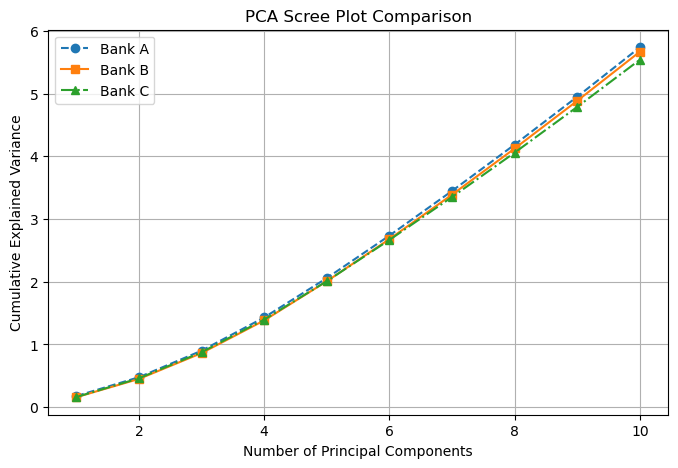

In [201]:
variance_A = [0.177, 0.301, 0.423, 0.530, 0.628, 0.678, 0.712, 0.739, 0.764, 0.788]
variance_B = [0.159, 0.292, 0.412, 0.521, 0.625, 0.672, 0.709, 0.736, 0.761, 0.783]
variance_C = [0.162, 0.299, 0.416, 0.520, 0.613, 0.658, 0.684, 0.708, 0.730, 0.752]

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), np.cumsum(variance_A), marker='o', linestyle='--', label="Bank A")
plt.plot(range(1, 11), np.cumsum(variance_B), marker='s', linestyle='-', label="Bank B")
plt.plot(range(1, 11), np.cumsum(variance_C), marker='^', linestyle='-.', label="Bank C")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot Comparison')
plt.legend()
plt.grid()
plt.show()


<hr>

In [73]:
def permutations(dataset):
    X = dataset.drop(columns=['income'])
    y = dataset['income']


    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    perm_importance = permutation_importance(
        model, X, y,
        scoring='accuracy',
        n_repeats=3,
        random_state=42,
        n_jobs=-1
    )

    sorted_idx = np.argsort(perm_importance.importances_mean)[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Top 10 Features - Permutation Importance")
    plt.tight_layout()
    plt.show()


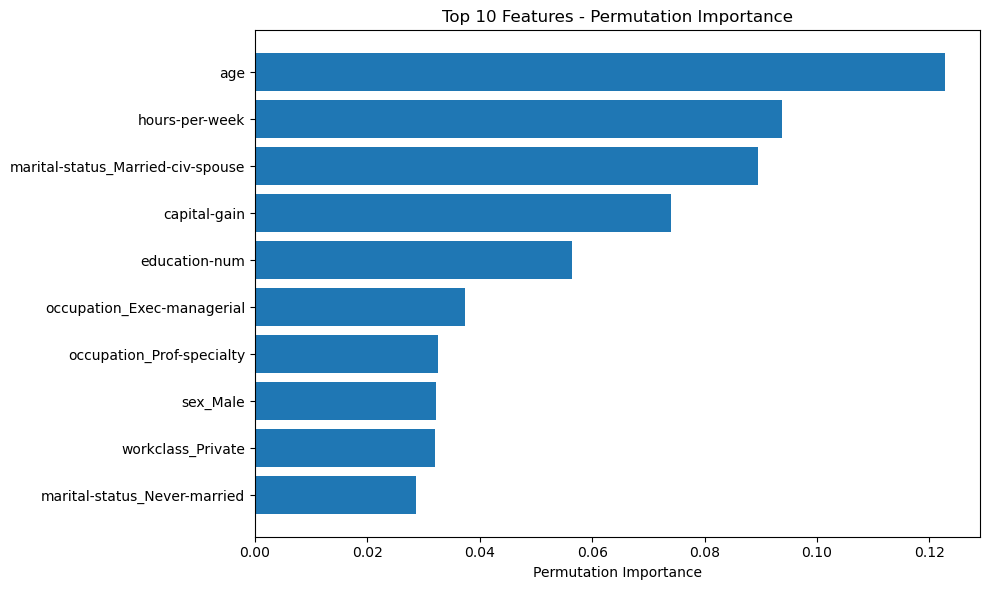

In [112]:
perm_bankA = permutations(bankA_data)

/Users/annina/miniconda3/envs/fl_banking/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


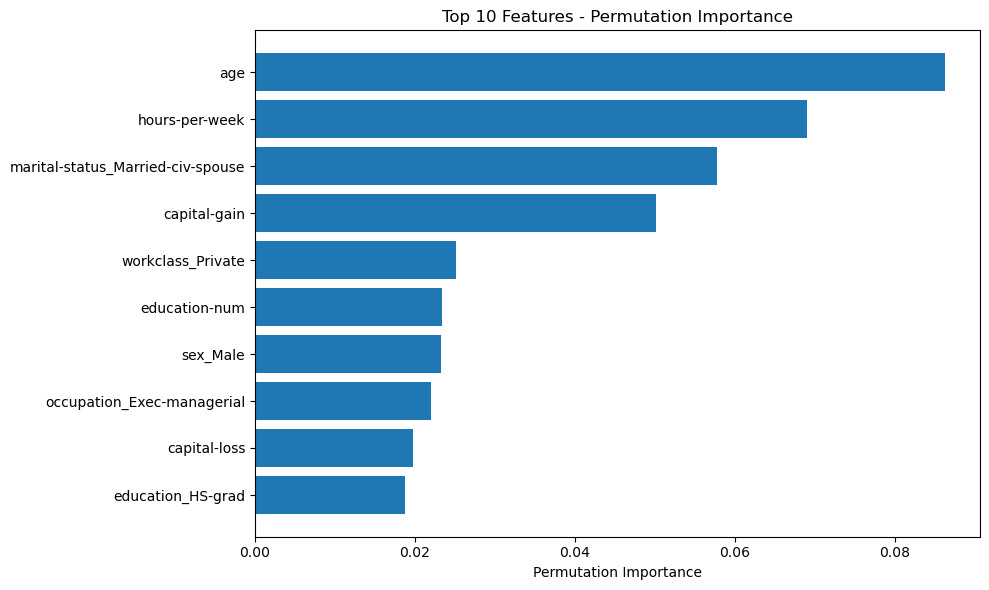

In [131]:
perm_bankB = permutations(bankB_data)

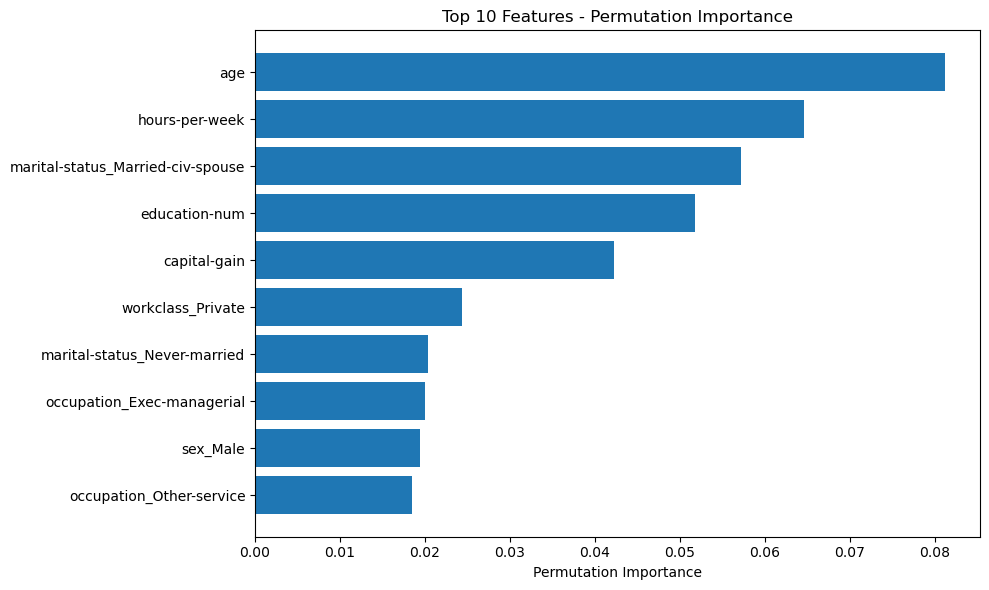

In [134]:
perm_bankC = permutations(bankC_data)

<hr>

In [212]:
def select_K_best(dataset, bank_name):
    """ Selects top-K features using Chi-Square test and returns scores """
    X = dataset.drop(columns=['income'])
    y = dataset['income']

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    selector = SelectKBest(score_func=chi2, k=10)
    X_new = selector.fit_transform(X_scaled, y)

    selected_feature_names = X.columns[selector.get_support()]
    scores = selector.scores_[selector.get_support()]

    selected_features_df = pd.DataFrame({'Feature': selected_feature_names, 'Score': scores, 'Bank': bank_name})
    return selected_features_df


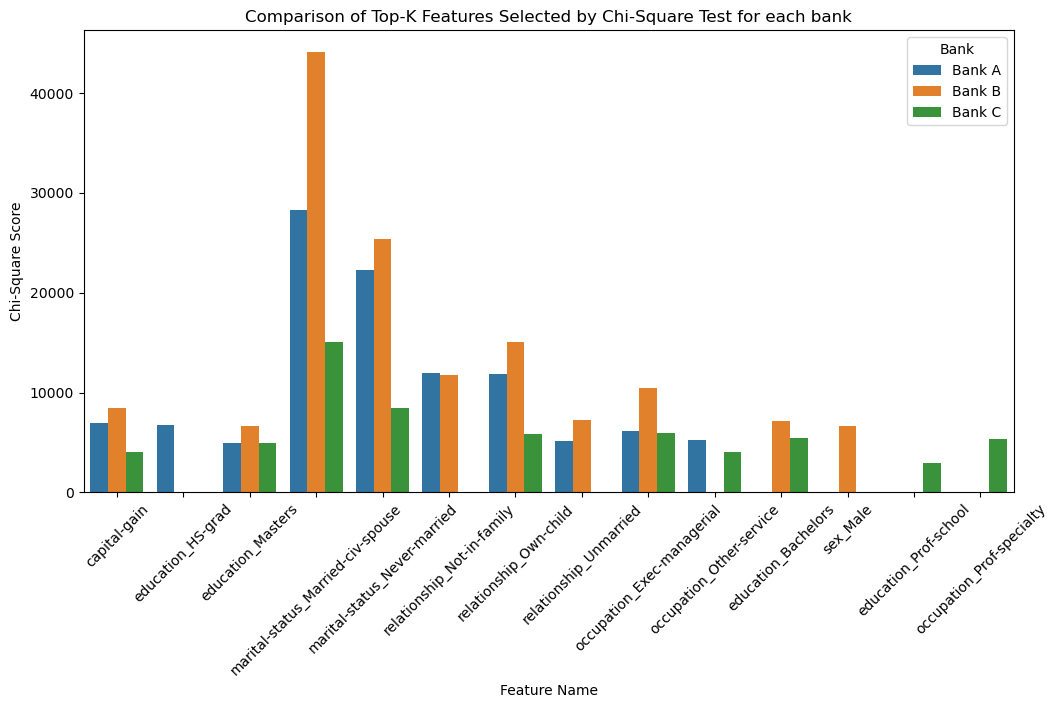

In [210]:
selected_A = select_K_best(bankA_data, "Bank A")
selected_B = select_K_best(bankB_data, "Bank B")
selected_C = select_K_best(bankC_data, "Bank C")

selected_features_all = pd.concat([selected_A, selected_B, selected_C])

plt.figure(figsize=(12,6))
sns.barplot(x="Feature", y="Score", hue="Bank", data=selected_features_all)
plt.xticks(rotation=45)
plt.title("Comparison of Top-K Features Selected by Chi-Square Test for each bank")
plt.xlabel("Feature Name")
plt.ylabel("Chi-Square Score")
plt.legend(title="Bank")
plt.show()

In [9]:
def create_correlation_matrix(selected_features, original_data):
    feature_names = selected_features['Feature']
    
    numeric_data = original_data[feature_names]
    
    if not all(numeric_data.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("All selected features must be numeric to compute a correlation matrix.")
    
    correlation_matrix = numeric_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="PiYG", linewidths=0.5)
    plt.title("Correlation Matrix of Selected Features")
    plt.show()



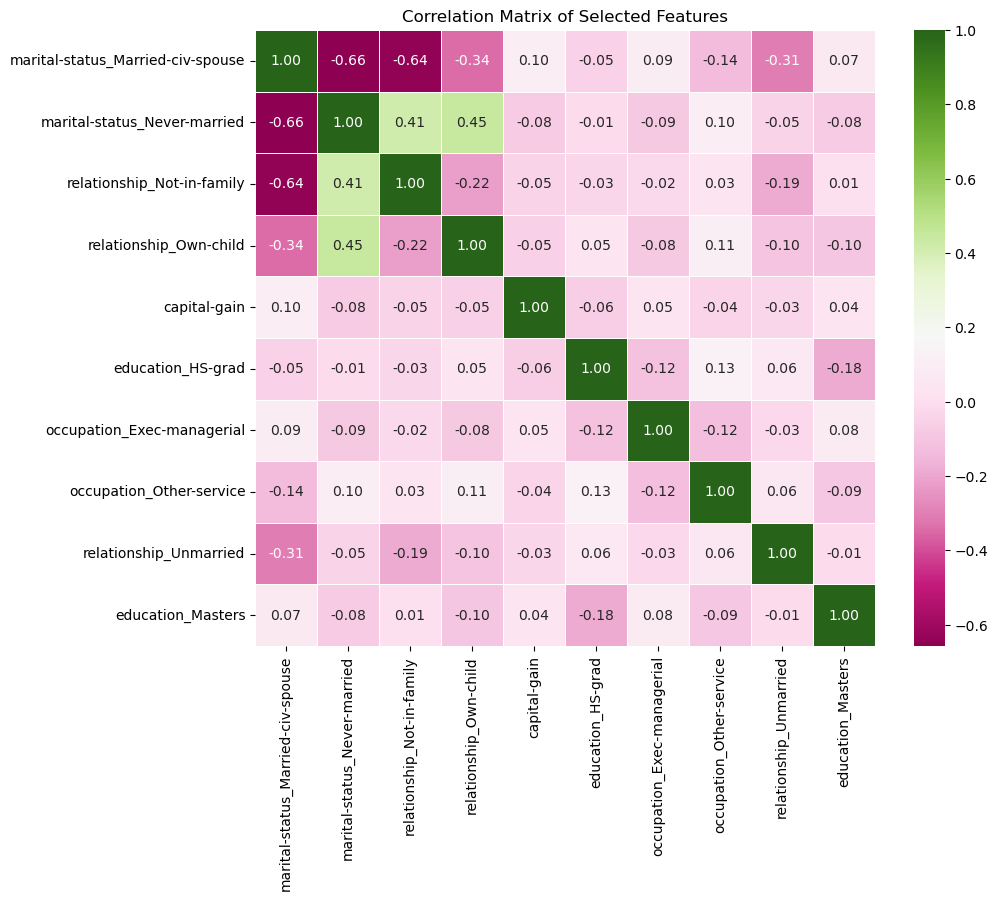

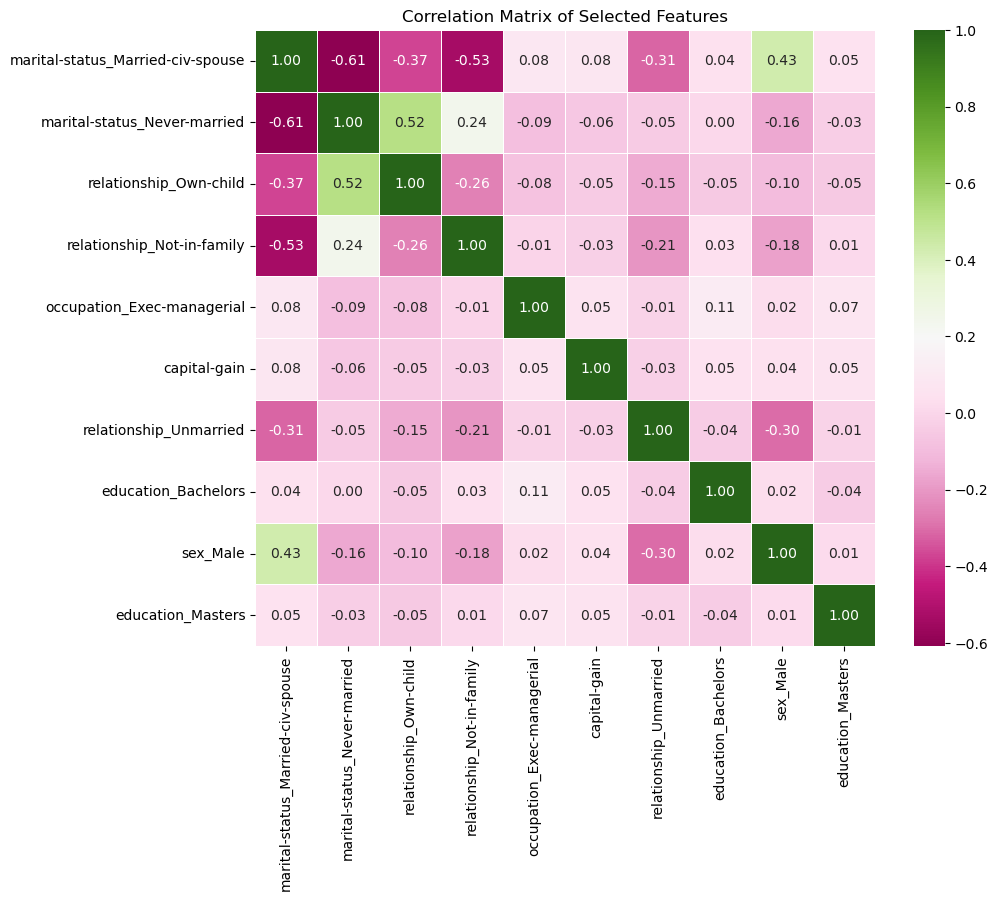

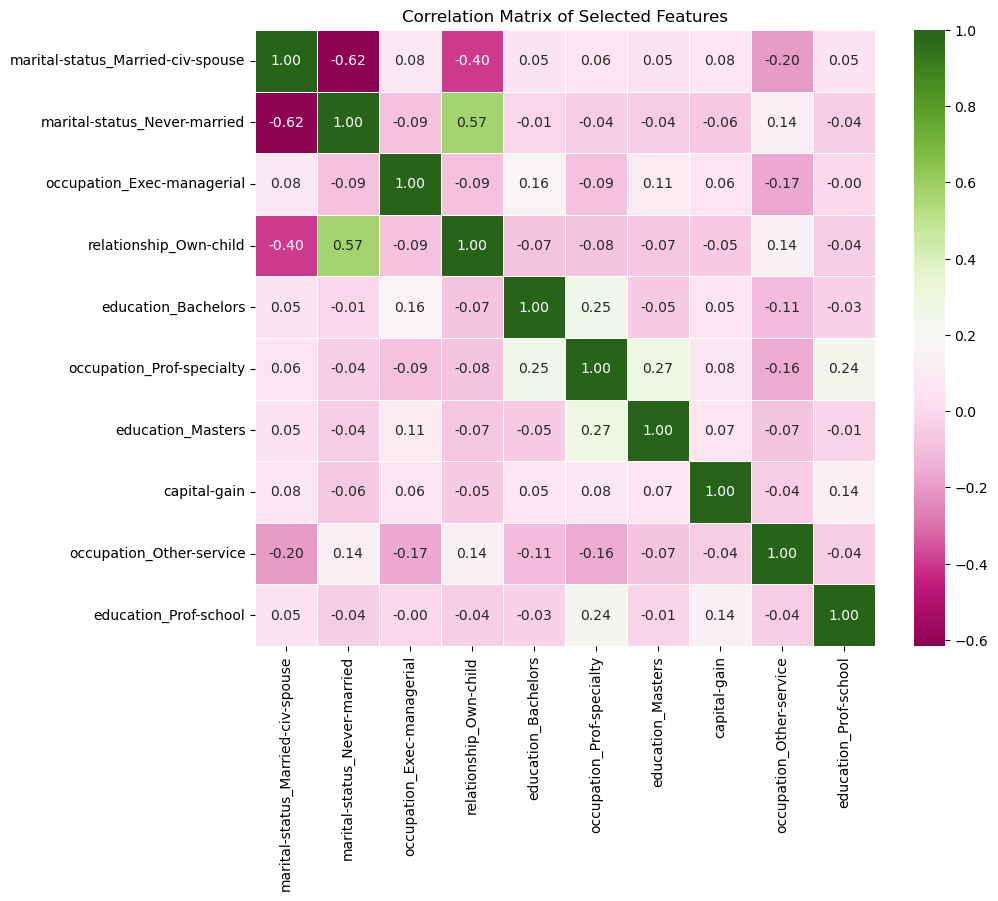

In [126]:
create_correlation_matrix(skb_bankA, filtered_bankA)
create_correlation_matrix(skb_bankB, filtered_bankB)
create_correlation_matrix(skb_bankC, filtered_bankC)


<hr>

In [178]:
data = [
    {"Bank": "BankA", "Feature": "marital-status_Married-civ-spouse", "Importance": 28287.805510},
    {"Bank": "BankA", "Feature": "marital-status_Never-married", "Importance": 22308.632680},
    {"Bank": "BankA", "Feature": "relationship_Not-in-family", "Importance": 11940.216582},
    {"Bank": "BankA", "Feature": "relationship_Own-child", "Importance": 11868.961633},
    {"Bank": "BankA", "Feature": "capital-gain", "Importance": 6911.586474},
    {"Bank": "BankA", "Feature": "education_HS-grad", "Importance": 6699.743352},
    {"Bank": "BankA", "Feature": "occupation_Exec-managerial", "Importance": 6171.470378},
    {"Bank": "BankA", "Feature": "occupation_Other-service", "Importance": 5284.569763},
    {"Bank": "BankA", "Feature": "relationship_Unmarried", "Importance": 5090.734934},
    {"Bank": "BankA", "Feature": "education_Masters", "Importance": 4976.794131},
    {"Bank": "BankB", "Feature": "marital-status_Married-civ-spouse", "Importance": 44094.847532},
    {"Bank": "BankB", "Feature": "marital-status_Never-married", "Importance": 25382.416066},
    {"Bank": "BankB", "Feature": "relationship_Own-child", "Importance": 15062.852315},
    {"Bank": "BankB", "Feature": "relationship_Not-in-family", "Importance": 11766.331373},
    {"Bank": "BankB", "Feature": "occupation_Exec-managerial", "Importance": 10416.164654},
    {"Bank": "BankB", "Feature": "capital-gain", "Importance": 8476.385813},
    {"Bank": "BankB", "Feature": "relationship_Unmarried", "Importance": 7239.242271},
    {"Bank": "BankB", "Feature": "education_Bachelors", "Importance": 7144.110795},
    {"Bank": "BankB", "Feature": "sex_Male", "Importance": 6633.954946},
    {"Bank": "BankB", "Feature": "education_Masters", "Importance": 6626.997797},
    {"Bank": "BankC", "Feature": "marital-status_Married-civ-spouse", "Importance": 15077.456389},
    {"Bank": "BankC", "Feature": "marital-status_Never-married", "Importance": 8488.184078},
    {"Bank": "BankC", "Feature": "occupation_Exec-managerial", "Importance": 5964.239727},
    {"Bank": "BankC", "Feature": "relationship_Own-child", "Importance": 5869.233627},
    {"Bank": "BankC", "Feature": "education_Bachelors", "Importance": 5444.468363},
    {"Bank": "BankC", "Feature": "occupation_Prof-specialty", "Importance": 5355.997433},
    {"Bank": "BankC", "Feature": "education_Masters", "Importance": 4985.777285},
    {"Bank": "BankC", "Feature": "capital-gain", "Importance": 4057.721492},
    {"Bank": "BankC", "Feature": "occupation_Other-service", "Importance": 4022.666006},
    {"Bank": "BankC", "Feature": "education_Prof-school", "Importance": 2947.749521},
]


In [180]:
feature_mapping = {
    "marital-status_Married-civ-spouse": "MarriedCivSpouse",
    "marital-status_Never-married": "NeverMarried",
    "relationship_Not-in-family": "NotInFamily",
    "relationship_Own-child": "OwnChild",
    "capital-gain": "CapitalGain",
    "education_HS-grad": "HSGrad",
    "occupation_Exec-managerial": "ExecManagerial",
    "occupation_Other-service": "OtherService",
    "relationship_Unmarried": "Unmarried",
    "education_Masters": "Masters",
    "education_Bachelors": "Bachelors",
    "occupation_Prof-specialty": "ProfSpecialty",
    "education_Prof-school": "ProfSchool",
    "sex_Male": "Male"
}


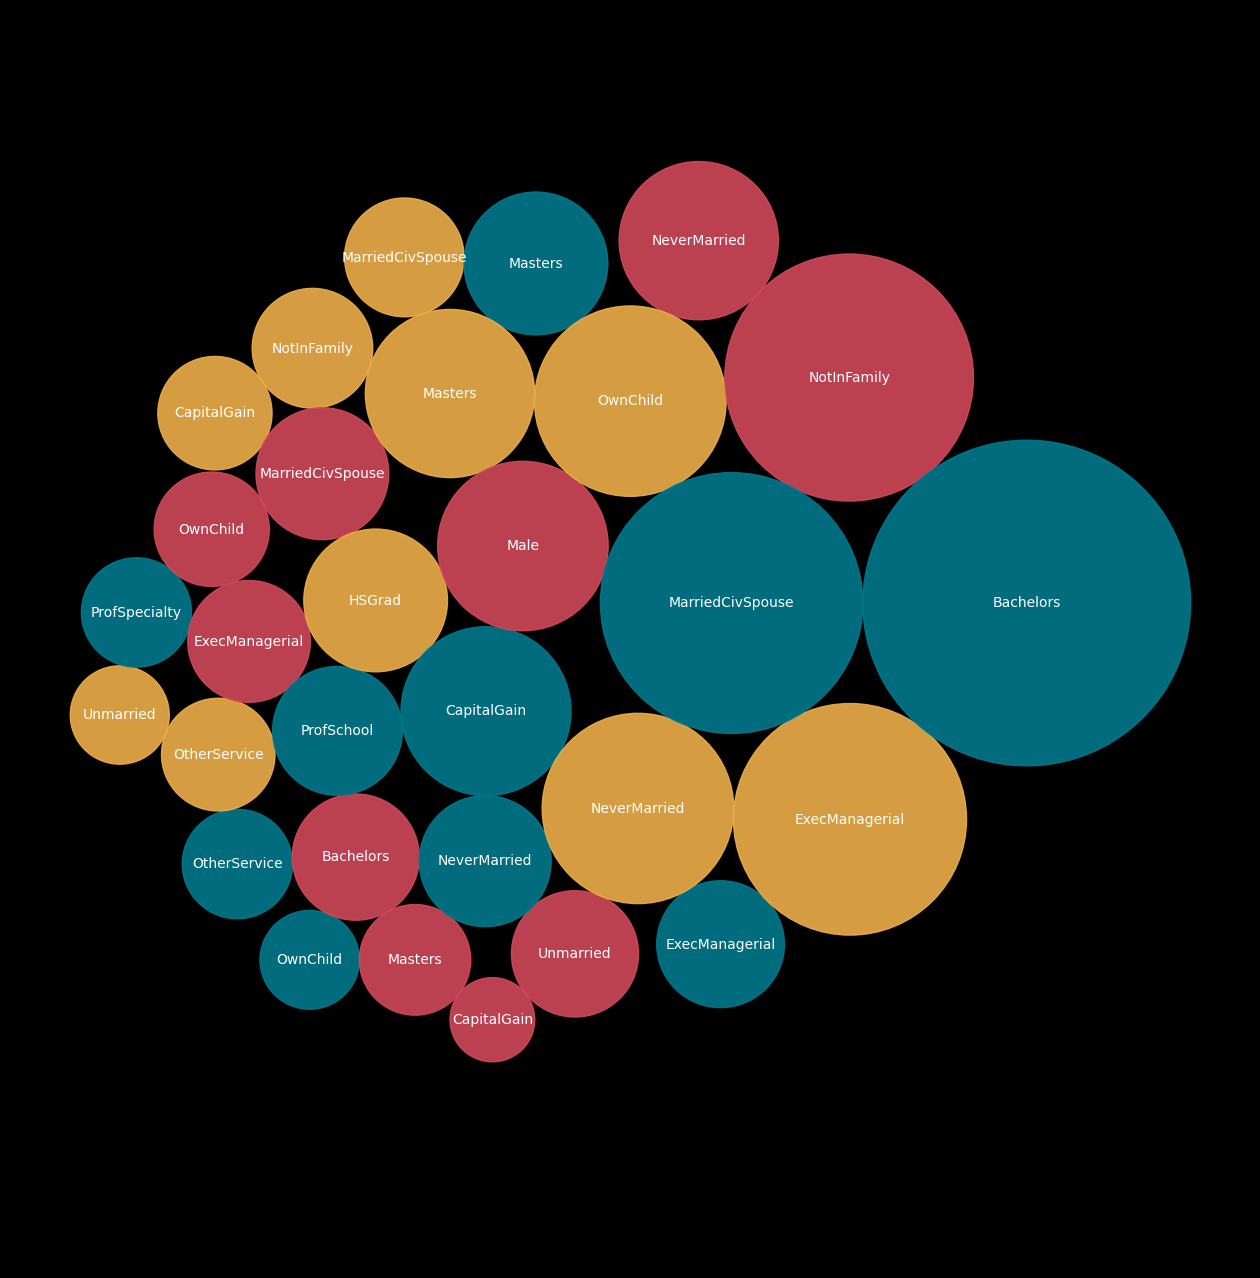

In [215]:
background_color = "#000000"

df = pd.DataFrame(data)
df["Feature"] = df["Feature"].replace(feature_mapping)
df = df.sample(frac=1).reset_index(drop=True)

circles = circlify.circlify(
    df['Importance'].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

fig, ax = plt.subplots(figsize=(16, 16))
fig.patch.set_facecolor(background_color)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.axis('off')

colors = {"BankA": "#edae49", "BankB": "#d1495b", "BankC": "#00798c"}

for circle, row in zip(circles, df.itertuples()):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, color=colors[row.Bank], alpha=0.9))
    plt.text(x, y, row.Feature, ha='center', va='center', fontsize=10, color='white')

plt.title("Feature Importance for each Bank", fontsize=16)
plt.show()


<hr>

In [67]:
dataA = [
    {"Bank": "BankA", "Feature": "Married", "Score": 28287.8, "Category": "Demographics"},
    {"Bank": "BankA", "Feature": "Never-married", "Score": 22308.6, "Category": "Demographics"},
    {"Bank": "BankA", "Feature": "Not-in-family", "Score": 11940.2, "Category": "Demographics"},
    {"Bank": "BankA", "Feature": "Own-child", "Score": 11868.9, "Category": "Demographics"},
    {"Bank": "BankA", "Feature": "Capital-gain", "Score": 6911.6, "Category": "Financial"},
    {"Bank": "BankA", "Feature": "HS-grad", "Score": 6699.7, "Category": "Education"},
    {"Bank": "BankA", "Feature": "Exec-managerial", "Score": 6171.5, "Category": "Work"},
    {"Bank": "BankA", "Feature": "Other-service", "Score": 5284.6, "Category": "Work"},
    {"Bank": "BankA", "Feature": "Unmarried", "Score": 5090.7, "Category": "Demographics"},
    {"Bank": "BankA", "Feature": "Masters", "Score": 4976.8, "Category": "Education"},
]

dataB = [
    {"Bank": "BankB", "Feature": "Married", "Score": 44094.8, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Never-married", "Score": 25382.4, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Own-child", "Score": 15062.8, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Not-in-family", "Score": 11766.3, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Exec-managerial", "Score": 10416.2, "Category": "Work"},
    {"Bank": "BankB", "Feature": "Capital-gain", "Score": 8476.4, "Category": "Financial"},
    {"Bank": "BankB", "Feature": "Unmarried", "Score": 7239.2, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Bachelors", "Score": 7144.1, "Category": "Education"},
    {"Bank": "BankB", "Feature": "Male", "Score": 6634.0, "Category": "Demographics"},
    {"Bank": "BankB", "Feature": "Masters", "Score": 6627.0, "Category": "Education"},
]

dataC = [
    {"Bank": "BankC", "Feature": "Married", "Score": 15077.5, "Category": "Demographics"},
    {"Bank": "BankC", "Feature": "Never-married", "Score": 8488.2, "Category": "Demographics"},
    {"Bank": "BankC", "Feature": "Exec-managerial", "Score": 5964.2, "Category": "Work"},
    {"Bank": "BankC", "Feature": "Own-child", "Score": 5869.2, "Category": "Demographics"},
    {"Bank": "BankC", "Feature": "Bachelors", "Score": 5444.5, "Category": "Education"},
    {"Bank": "BankC", "Feature": "Prof-specialty", "Score": 5356.0, "Category": "Work"},
    {"Bank": "BankC", "Feature": "Masters", "Score": 4985.8, "Category": "Education"},
    {"Bank": "BankC", "Feature": "Capital-gain", "Score": 4057.7, "Category": "Financial"},
    {"Bank": "BankC", "Feature": "Other-service", "Score": 4022.7, "Category": "Work"},
    {"Bank": "BankC", "Feature": "Prof-school", "Score": 2947.7, "Category": "Education"}
]


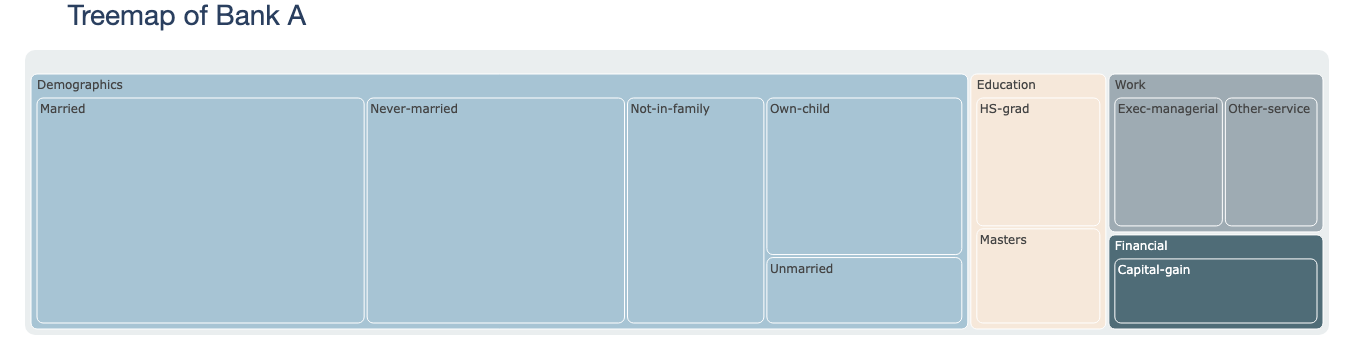

In [98]:
dfA = pd.DataFrame(dataA)

color_mapA = {
    "BankA_Demographics": "#A7C4D4",
    "BankA_Education": "#F6E8DA",
    "BankA_Work": "#9EABB3",
    "BankA_Financial": "#4F6C77"
}

dfA["ColorCategory"] = dfA["Bank"] + "_" + dfA["Category"]

fig = px.treemap(
    dfA,
    path=["Category", "Feature"],
    values="Score",
    color="ColorCategory",
    color_discrete_map=color_mapA,
    title="Treemap of Bank A"
)
fig.update_layout(
    title_font_size=28,
    title_font_family="Helvetica Neue",
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    root_color="#EAEEEF",
    marker=dict(cornerradius=10)
)

fig.show()

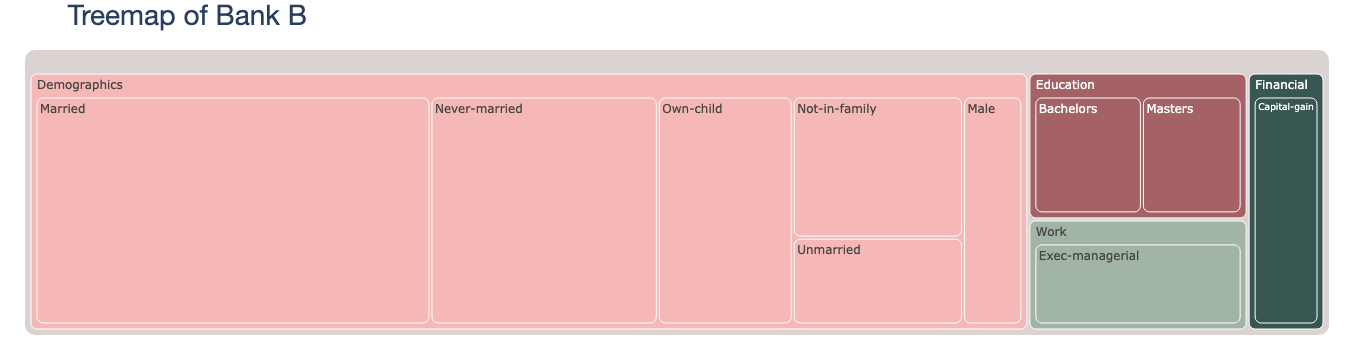

In [96]:
dfB = pd.DataFrame(dataB)

color_mapB = {
    "BankB_Demographics": "#F5B8B6",
    "BankB_Education": "#A56266",
    "BankB_Work": "#A1B4A5",
    "BankB_Financial": "#385752"
}

dfB["ColorCategory"] = dfB["Bank"] + "_" + dfB["Category"]

fig = px.treemap(
    dfB,
    path=["Category", "Feature"],
    values="Score",
    color="ColorCategory",
    color_discrete_map=color_mapB,
    title="Treemap of Bank B"
)
fig.update_layout(
    title_font_size=28,
    title_font_family="Helvetica Neue",
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    root_color="#DBD3D1",
    marker=dict(cornerradius=10)
)
fig.show()

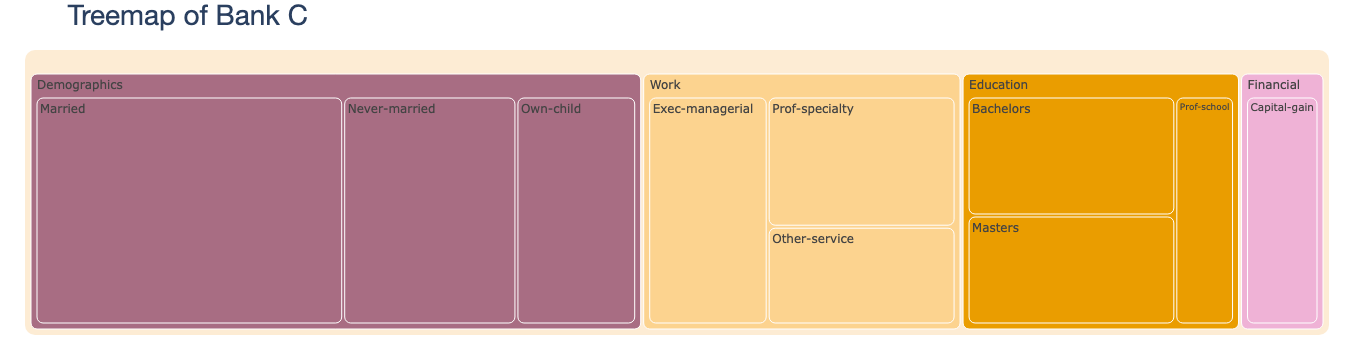

In [97]:
dfC = pd.DataFrame(dataC)

color_mapC = {
    "BankC_Demographics": "#A86D83",
    "BankC_Education": "#EA9D00",
    "BankC_Work": "#FCD38F",
    "BankC_Financial": "#EFB2D6",
}

dfC["ColorCategory"] = dfC["Bank"] + "_" + dfC["Category"]

fig = px.treemap(
    dfC,
    path=["Category", "Feature"],
    values="Score",
    color="ColorCategory",
    color_discrete_map=color_mapC,
    title="Treemap of Bank C"
)
fig.update_layout(
    title_font_size=28,
    title_font_family="Helvetica Neue",
    margin=dict(t=50, l=25, r=25, b=25),
)

fig.update_traces(
    root_color="#FDECD4",
    marker=dict(cornerradius=10)
)

fig.show()

In [218]:
def shuffle_data(dataset):
    shuffled_data = dataset.copy()
    shuffled_data['income'] = np.random.permutation(shuffled_data['income'])
    
    X = shuffled_data.drop(columns=["income"])
    y = shuffled_data["income"]
    
    dtrain = xgb.DMatrix(X, label=y)
    
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 6,
        "learning_rate": 0.1,
        "subsample": 1.0,
    }
    bst = xgb.train(params, dtrain, num_boost_round=50)
    
    y_pred = bst.predict(dtrain)
    auc = roc_auc_score(y, y_pred)
    print(f"Shuffled Target AUC: {auc}")


In [220]:
shuffle_data(bankA_data)
shuffle_data(bankB_data)
shuffle_data(bankC_data)

Shuffled Target AUC: 0.5485833808024942
Shuffled Target AUC: 0.5421316753657023
Shuffled Target AUC: 0.5707962219176389


In [224]:
def calc_scale_pos_weight(data):
    num_positive = len(data[data['income'] == 1])
    num_negative = len(data[data['income'] == 0])
    
    scale_pos_weight = num_negative / num_positive
    print(f"Scale_pos_weight: {scale_pos_weight}")


In [225]:
calc_scale_pos_weight(bankA_data)
calc_scale_pos_weight(bankB_data)
calc_scale_pos_weight(bankC_data)

Scale_pos_weight: 1.7127626440499293
Scale_pos_weight: 3.6945949409859367
Scale_pos_weight: 4.850564070911772
